# Tracking with manually annotated edges

In [ ]:
%pip install -q --upgrade -r requirements.txt

## Initializing napari

In [1]:
import napari
import numpy as np
import pandas as pd
import json
from IPython.display import display
from skimage.io import imread
from skimage.measure import regionprops_table
from matplotlib import pyplot as plt

from laptrack import LapTrack

In [2]:
images = imread("napari_interactive_fix_data/example_images.tif")
labels = imread("napari_interactive_fix_data/example_label.tif")

In [3]:
viewer = napari.Viewer()
viewer.add_image(images, name="images")
viewer.add_labels(labels, name="labels")
original_camera_state=viewer.camera.dict()
with open("napari_interactive_fix_data/camera_state.json","r") as f:
    camera_state=json.load(f)

## Calculating centroids of the segmentation

In [4]:
def calc_frame_regionprops(labels):  # noqa: E302
    dfs = []
    for frame in range(labels.shape[0]):
        df = pd.DataFrame(
            regionprops_table(labels[frame], properties=["label", "centroid"])
        )
        df["frame"] = frame
        dfs.append(df)
    return pd.concat(dfs)


regionprops_df = calc_frame_regionprops(labels)
display(regionprops_df.head())

,label,centroid-0,centroid-1,frame
0,3,103.091603,195.816794,0
1,25,151.812048,15.674699,0
2,35,31.552063,43.740668,0
3,59,60.389432,76.156556,0
4,64,125.100457,21.646119,0


## Tracking by LapTrack

In [5]:
lt = LapTrack(
    track_cost_cutoff=100**2, 
    splitting_cost_cutoff=20**2
)
track_df, split_df, _ = lt.predict_dataframe(
    regionprops_df,
    coordinate_cols=["centroid-0","centroid-1"],
    only_coordinate_cols=False
)
track_df.head()

label  centroid-0  centroid-1  frame_y  tree_id  track_id
frame index                                                           
0     0          3  103.091603  195.816794        0        0         0
      1         25  151.812048   15.674699        0        1         1
      2         35   31.552063   43.740668        0        2         2
      3         59   60.389432   76.156556        0        3         3
      4         64  125.100457   21.646119        0        4         4

## Adding the tracked data to the viewer

In [6]:
track_label_image = np.zeros_like(labels)
for (frame, _), row in track_df.iterrows():
    track_label_image[frame][labels[frame] == row["label"]] = row["track_id"] + 1

In [7]:
viewer.layers["labels"].visible = False
viewer.add_labels(track_label_image)

<Labels layer 'track_label_image' at 0x1800c6a70>

Take screenshot of currente state

In [8]:
plt.figure(figsize=(6,3))
viewer.camera.update(camera_state)
viewer.dims.current_step = (1, 0, 0)
screenshot_before1=viewer.screenshot()
viewer.dims.current_step = (2, 0, 0)
screenshot_before2=viewer.screenshot()
viewer.camera.update(original_camera_state)

<Figure size 600x300 with 0 Axes>

## Manual correction

add points for the cells validated maually (emurated)

In [9]:
manual_corrected = np.load("napari_interactive_fix_data/manual_corrected.npy")
viewer.add_points(manual_corrected, name="manually_validated_tracks",size=500,face_color="red")

<Points layer 'manually_validated_tracks' at 0x181b93520>

In [10]:
manual_corrected = viewer.layers["manually_validated_tracks"].data.astype(np.int16)
# you can also redraw the labels
new_labels = viewer.layers["track_label_image"].data
# get label values at the placed points
validated_track_labels = new_labels[tuple(manual_corrected.T)]
validated_frames = manual_corrected[:, 0]

In [11]:
new_regionprops_df = (
    calc_frame_regionprops(new_labels).reset_index(drop=True)
)
new_regionprops_df.head()

,label,centroid-0,centroid-1,frame
0,1,103.091603,195.816794,0
1,2,151.812048,15.674699,0
2,3,31.552063,43.740668,0
3,4,60.389432,76.156556,0
4,5,125.100457,21.646119,0


In [12]:
validated_points = np.array(list(zip(validated_frames, validated_track_labels)))
validated_points = validated_points[np.argsort(validated_points[:, 0])]
print(validated_points)

[[ 0 34]
 [ 1 34]
 [ 2  6]
 [ 3  4]
 [ 4  9]
 [ 5  9]]


get the validated edges in terms of the `iloc` of the dataframe (making use of the index this time)

In [13]:
def get_iloc(frame,label):
    df = new_regionprops_df[
        (new_regionprops_df["frame"] == frame) & 
        (new_regionprops_df["label"] == label)
    ]
    assert len(df) == 1
    return df.iloc[0].name

validated_point_ilocs = [
    get_iloc(frame,label) for frame,label in validated_points
]
validated_point_iloc_pairs = list(zip(validated_point_ilocs[:-1],validated_point_ilocs[1:]))
print(validated_point_iloc_pairs)
display(new_regionprops_df.iloc[validated_point_ilocs])

[(33, 69), (69, 88), (88, 132), (132, 182), (182, 230)]


,label,centroid-0,centroid-1,frame
33,34,108.448276,108.586207,0
69,34,92.097561,112.112805,1
88,6,68.569405,116.014164,2
132,4,52.942993,114.076010,3
182,9,36.493888,117.039120,4
230,9,41.824363,113.631728,5


## Second tracking preserving manually corrected data

`validated_point_iloc_pairs` ... pairs of the `iloc`s of the validated points

In [14]:
lt = LapTrack(track_cost_cutoff=100**2, splitting_cost_cutoff=20**2)
new_track_df, _new_split_df, _ = lt.predict_dataframe(new_regionprops_df, 
                                            coordinate_cols=["centroid-0","centroid-1"],
                                            only_coordinate_cols=False,
                                            connected_edges=validated_point_iloc_pairs)

In [15]:
new_track_df

label  centroid-0  centroid-1  frame_y  tree_id  track_id
frame index                                                           
0     0          1  103.091603  195.816794        0        0         0
      1          2  151.812048   15.674699        0        1         1
      2          3   31.552063   43.740668        0        2         2
      3          4   60.389432   76.156556        0        3         3
      4          5  125.100457   21.646119        0        4         4
...            ...         ...         ...      ...      ...       ...
5     45        55   95.888179   48.552716        5       42        54
      46        56  188.176301   71.471098        5       38        55
      47        57   20.024096  196.915663        5       11        56
      48        58  193.452991   89.854701        5       38        57
      49        59    4.693182  191.176136        5       11        58

[273 rows x 6 columns]

## Adding updated data to viewer

In [16]:
new_track_label_image = np.zeros_like(new_labels)
for (frame, _), row in new_track_df.iterrows():
    new_track_label_image[frame][new_labels[frame] == row["label"]] = row["track_id"] + 1
viewer.layers["track_label_image"].visible = False
viewer.add_labels(new_track_label_image)

<Labels layer 'new_track_label_image' at 0x160c9bc40>

Take screenshot of currente state

In [17]:
plt.figure(figsize=(6,3))
viewer.camera.update(camera_state)

<Figure size 600x300 with 0 Axes>

In [18]:
plt.figure(figsize=(6,3))
viewer.layers.move_multiple([3],5)
viewer.camera.update(camera_state)
viewer.dims.current_step = (1, 0, 0)
screenshot_after1=viewer.screenshot()
viewer.dims.current_step = (2, 0, 0)
screenshot_after2=viewer.screenshot()
viewer.camera.update(original_camera_state)

<Figure size 600x300 with 0 Axes>

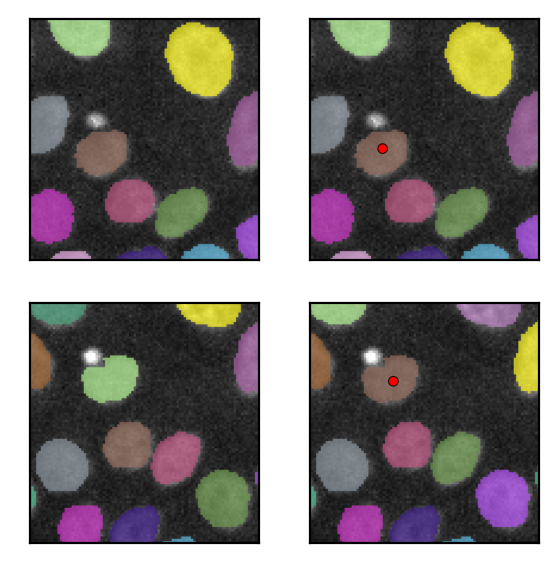

In [20]:
fig, axes =plt.subplots(2,2,figsize=(3,3))
screenshots=[screenshot_before1,screenshot_before2,screenshot_after1,screenshot_after2]
for ax, img in zip(np.ravel(axes.T),screenshots):
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

In [22]:
# camera_state = viewer.camera.dict()
# with open("napari_interactive_fix_data/camera_state.json","w") as f:
#     json.dump(camera_state,f)